<a id='Q0'></a>
<center> <h1> Notebook 1: Basic EDA and Modelling </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><strong>Angela Niederberger, 2022</strong></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> In this notebook I explore the Swiss Rents Dataset and build two basic baseline models.</p>
        <strong> Outline:</strong>
        <a id='P0' name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href='#I'>Introduction </a> </li>
            <li> <a style="color:#303030" href='#SU'>Set up</a></li>
            <li> <a style="color:#303030" href='#P1'>Exploratory Data Analysis</a></li>
            <li> <a style="color:#303030" href='#P2'>Modelling Pipeline</a></li>
            <li> <a style="color:#303030" href='#CL'>Conclusion</a></li>
        </ol>
        <strong>Keywords:</strong> Exploratory Data Analysis, Visualization, Linear Regression, Random Forest Regression
    </div>
</div>
</nav>

<a id='I' name="I"></a>
## [Introduction](#P0)

Here you could write an introduction to the topics. Everything that is written here will appear in the live coding template notebook

<a id='SU' name="SU"></a>
## [Set up](#P0)

### Packages

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

### Magic Commands

In [2]:
#%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

### Global Parameters Setting

In [3]:
plt.style.use("seaborn")
sns.set_theme(style="ticks")

### User-Dependent Variables

In [4]:
raw_data = "../data/raw"

os.getcwd()

'/home/angela/Documents/Python/swiss_rents/notebooks'

### Helper Functions

In [ ]:
def adjusted_r2_score(y_true, y_pred, X_test):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X_test.shape[1] - 1)
    return adjusted_r2

<a id='P1'></a>
## [Exploratory Data Analysis](#P0)

This section will help us understand the data.

### Read in and Split the Data

First we'll read in the raw and processed data sets and then split the raw data set into training and test set, since this is the best practice whenever building machine learning models.

In [11]:
# Data from: https://datenportal.info/wohnungsmarkt/wohnungsmieten/

df_raw = pd.read_csv(f"{raw_data}/mietinserate_v1.csv", sep=";")
df_raw.head()

,ID,Jahr,Quartal,Wohnungstyp,Zimmer,Fläche,Mietpreis_Brutto,Quadratmeterpreis_Brutto,Adresse,PLZ_Ort,Bezugsdatum,GKODE,GKODN,"KT,"
0,1,2019,4,Wohnung,4.5,NaN,1850,NaN,Aachstrasse 13,9327 Tübach,NaN,2752059.0,1261281.0,"SG,"
1,2,2019,2,Wohnung,3.5,75.0,1180,16.0,Aachstrasse 29,8586 Erlen,NaN,2734483.0,1268102.0,"TG,"
2,3,2019,4,Maisonettewohnung,3.5,NaN,1400,NaN,Aachstrasse 31b,8586 Erlen,NaN,2734427.0,1268073.0,"TG,"
3,4,2019,2,Wohnung,4.5,NaN,1750,NaN,Aachstrasse 5,9327 Tübach,NaN,2751994.0,1261267.0,"SG,"
4,5,2019,2,Wohnung,5.5,NaN,2450,NaN,Aachstrasse 5,9327 Tübach,NaN,2751994.0,1261267.0,"SG,"


The first thing we do is to split the data to ensure that our test dataset is really unseen data. We will try to predict the rent, which is the 'Mietpreis_Brutto'.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    df_raw.drop(columns="Mietpreis_Brutto"),
    df_raw["Mietpreis_Brutto"],
    test_size=0.3,
    random_state=42,
)

In [93]:
print("Training set:", X_train.shape, "Test set:", X_test.shape)

Training set: (39743, 13) Test set: (17034, 13)


### Data Cleaning

The data cleaning script needs to be reproducible, so that we can perform the same cleaning on the test set as we used on the training set. Below is the function used for cleaning the training set.

In [94]:
def clean_swiss_rents_data(df):
    # Turn PLZ_Ort into two independent columns
    df["Ort"] = df["PLZ_Ort"].str.split(" ", 1).str[1]
    df["PLZ"] = df["PLZ_Ort"].str.split(" ", 1).str[0].astype("int")
    # Remove all the unnecessary commas
    df["KT,"] = df["KT,"].str.replace(",", "")
    df.rename(columns={"KT,": "KT"}, inplace=True)
    return df

In [95]:
X_train_clean = clean_swiss_rents_data(X_train)
X_train_clean.head()

,ID,Jahr,Quartal,Wohnungstyp,Zimmer,Fläche,Quadratmeterpreis_Brutto,Adresse,PLZ_Ort,Bezugsdatum,GKODE,GKODN,KT,Ort,PLZ
25922,25923,2019,4,Wohnung,2.5,59.0,24.0,Kornweg 5,5415 Nussbaumen AG,NaN,2663786.0,1259907.0,AG,Nussbaumen AG,5415
56317,56318,2019,4,Wohnung,1.5,58.0,36.0,Zollstrasse 51,8005 Zürich,01.10.2019,2682706.0,1248306.0,ZH,Zürich,8005
19393,19394,2019,2,Wohnung,4.0,86.0,18.0,Hauptstrasse 16,4411 Seltisberg,01.04.2019,2621086.0,1256700.0,BL,Seltisberg,4411
55319,55320,2019,4,Wohnung,4.0,80.0,14.0,Winkelriedstrasse 4,9320 Arbon,01.10.2019,2749222.0,1263856.0,TG,Arbon,9320
50313,50314,2019,2,Wohnung,3.5,71.0,19.0,Via al Castello 4c,6964 Davesco-Soragno,NaN,2719003.0,1099407.0,TI,Davesco-Soragno,6964


### Visualization

In [203]:
viz_df = pd.concat([X_train_feat, y_train], axis=1)

#### Regression Pairplots

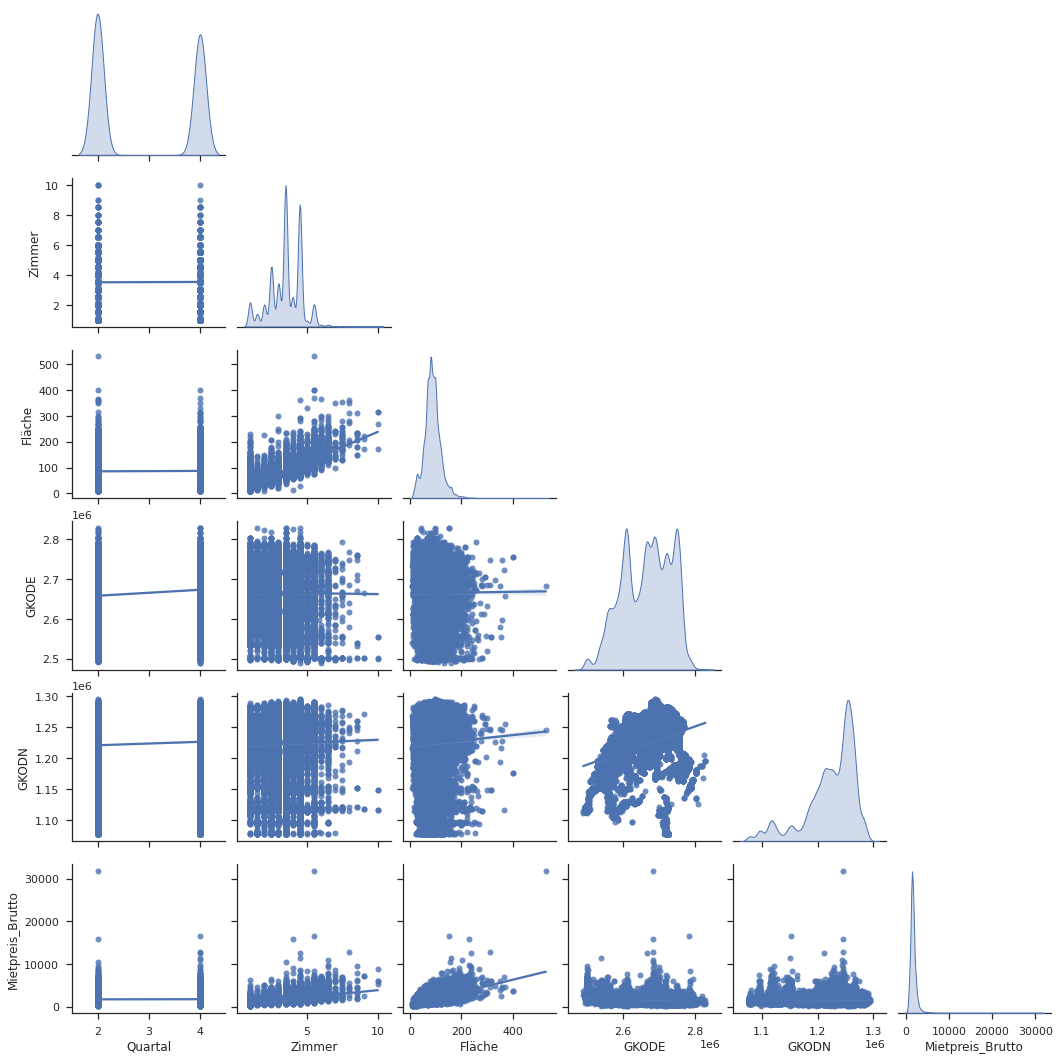

In [204]:
sns.pairplot(viz_df, kind="reg", diag_kind="kde", corner=True)

There seem to be linear relations between the rents and the number of rooms and size of the apartments. Location-wise there also appear to be some non-linear relationships between the geographical coordinates of the apartments and their rents, which would make a lot of sense. PLZ is here shown as a numeric feature, but it is actually categorical, so we need to be careful with it.

We can also see that there are some pretty massive outliers in the rents. It might make sense to remove those.

#### Correlation Matrix

<AxesSubplot:>

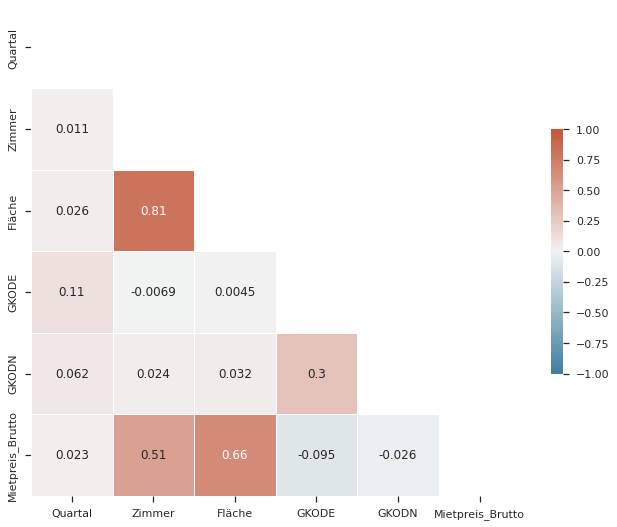

In [205]:
# Compute the correlation matrix
corr = viz_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

From the correlation matrix we can see that we should not use ``PLZ`` and ``GKODE`` as features for the same model, since they are highly correlated. The correlation between ``Zimmer`` and ``Fläche`` is also quite high, but we'll keep both of these features for now.

### Feature Selection

In [112]:
X_train_clean.columns

Index(['ID', 'Jahr', 'Quartal', 'Wohnungstyp', 'Zimmer', 'Fläche',
       'Quadratmeterpreis_Brutto', 'Adresse', 'PLZ_Ort', 'Bezugsdatum',
       'GKODE', 'GKODN', 'KT', 'Ort', 'PLZ'],
      dtype='object')

In [113]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39743 entries, 25922 to 56422
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        39743 non-null  int64  
 1   Jahr                      39743 non-null  int64  
 2   Quartal                   39743 non-null  int64  
 3   Wohnungstyp               39734 non-null  object 
 4   Zimmer                    39589 non-null  float64
 5   Fläche                    33931 non-null  float64
 6   Quadratmeterpreis_Brutto  33895 non-null  float64
 7   Adresse                   39743 non-null  object 
 8   PLZ_Ort                   39743 non-null  object 
 9   Bezugsdatum               27398 non-null  object 
 10  GKODE                     39743 non-null  float64
 11  GKODN                     39743 non-null  float64
 12  KT                        39743 non-null  object 
 13  Ort                       39743 non-null  object 
 14  PL

In [114]:
sum(X_train_clean["Adresse"].value_counts() <= 2)

24503

Which columns could be useful for modelling?
- The first thing to note is that the variable ``Quadratmeterpreis_Brutto`` would introduce data leakage, since it is simply the rent devided by the floor space. It needs to be removed.
- The year is 2019 for all observations, so it is not informative.
- The variable ``Bezugsdatum`` contains a lot of missing values, so it's probably better to drop it.
- The address is too granular to be useful, since most addresses appear only once or twice.
- The variable ``PLZ_Ort`` can be dropped since we've created two separate variables (``PLZ`` and ``Ort``) from it.
- However, we need to drop the ``PLZ`` column, since it is highly correlated with ``GKODE``.
- The ``ID`` column is also not useful.

For now, we select the columns ``Quartal``, ``Wohnungstyp``, ``Zimmer``, ``Fläche``, ``GKODE``, ``GKODN``, ``KT`` and ``Ort``.

In [115]:
def select_swiss_rents_features(df, column_names):
    df = df.loc[:, column_names]
    return df

In [149]:
cols_to_select = [
    "Quartal",
    "Wohnungstyp",
    "Zimmer",
    "Fläche",
    "GKODE",
    "GKODN",
    "KT",
    "Ort",
]

X_train_feat = select_swiss_rents_features(X_train_clean, cols_to_select)
X_train_feat.head()

,Quartal,Wohnungstyp,Zimmer,Fläche,GKODE,GKODN,KT,Ort
25922,4,Wohnung,2.5,59.0,2663786.0,1259907.0,AG,Nussbaumen AG
56317,4,Wohnung,1.5,58.0,2682706.0,1248306.0,ZH,Zürich
19393,2,Wohnung,4.0,86.0,2621086.0,1256700.0,BL,Seltisberg
55319,4,Wohnung,4.0,80.0,2749222.0,1263856.0,TG,Arbon
50313,2,Wohnung,3.5,71.0,2719003.0,1099407.0,TI,Davesco-Soragno


### Imputing Missing Values

In [150]:
X_train_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39743 entries, 25922 to 56422
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Quartal      39743 non-null  int64  
 1   Wohnungstyp  39734 non-null  object 
 2   Zimmer       39589 non-null  float64
 3   Fläche       33931 non-null  float64
 4   GKODE        39743 non-null  float64
 5   GKODN        39743 non-null  float64
 6   KT           39743 non-null  object 
 7   Ort          39743 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 3.7+ MB


Since there are some missing values in ``Wohnungstyp``, ``Zimmer`` and ``Fläche``, it is necessary to either drop these rows or to define imputation strategies for these. 6000 rows is quite a lot, so I'll try with imputation first.

In [151]:
def impute_missing_values(df, categorical_feat, fill_value, numeric_feat):
    # Categorical imputation with SimpleImputer
    simple_imputer = SimpleImputer(strategy="constant", fill_value=fill_value)
    df.loc[:, cat_feat] = simple_imputer.fit_transform(df.loc[:, cat_feat])

    # Numeric imputation with KNN
    knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
    df.loc[:, num_feat] = knn_imputer.fit_transform(df.loc[:, num_feat])

    return df

In [152]:
cat_feat = ["Wohnungstyp"]
num_feat = ["Zimmer", "Fläche"]
imp_string = "typ-unbekannt"

X_train_imp = impute_missing_values(X_train_feat, cat_feat, imp_string, num_feat)
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39743 entries, 25922 to 56422
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Quartal      39743 non-null  int64  
 1   Wohnungstyp  39743 non-null  object 
 2   Zimmer       39743 non-null  float64
 3   Fläche       39743 non-null  float64
 4   GKODE        39743 non-null  float64
 5   GKODN        39743 non-null  float64
 6   KT           39743 non-null  object 
 7   Ort          39743 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 3.7+ MB


In [153]:
X_train_imp["Wohnungstyp"].value_counts()

Wohnung              37314
Attikawohnung         1395
Maisonettewohnung      686
Studio                 217
Loftwohnung            122
typ-unbekannt            9
Name: Wohnungstyp, dtype: int64

I'm using a simple function here, but the imputation could also be performed in a pipeline, which would be more reliable.

## Modelling Pipeline

### Build the Pre-Processor

It is necessary to separate categorical from numeric features for the pre-processing steps. Missing values in categorical features will be imputed with a simple imputer. Then the features will be one-hot encoded. For numerica features a KNN Imputer is used and they are then scaled with the StandardScaler.

In [166]:
X_train_feat.dtypes

Quartal          int64
Wohnungstyp     object
Zimmer         float64
Fläche         float64
GKODE          float64
GKODN          float64
KT              object
Ort             object
dtype: object

In [167]:
categorical_features = X_train_feat.select_dtypes(include=["object"]).columns.tolist()

numeric_features = X_train_feat.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

#### Categorical Features

In [157]:
imp_string = "typ-unbekannt"

categorical_transformer = Pipeline(
    steps=[
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value=imp_string)),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
categorical_transformer

Pipeline(steps=[('cat_imputer',
                 SimpleImputer(fill_value='typ-unbekannt',
                               strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#### Numeric Features

In [169]:
numeric_transformer = Pipeline(
    steps=[
        ("knn_imputer", KNNImputer(n_neighbors=3)), 
        ("scaler", StandardScaler())
    ]
)

numeric_transformer

Pipeline(steps=[('knn_imputer', KNNImputer(n_neighbors=3)),
                ('scaler', StandardScaler())])

#### Combine the two

In [170]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='typ-unbekannt',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Wohnungstyp', 'KT', 'Ort']),
                                ('num',
                                 Pipeline(steps=[('knn_imputer',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['Quartal', 'Zimmer', 'Fläche', 'GKODE',
                                  'GKODN'])])

### Baseline Model

#### Build and Fit the Pipeline

In [172]:
lin_model = LinearRegression()
lin_model

LinearRegression()

In [173]:
pipeline_lr = Pipeline(steps=[("pre_process", preprocessor), ("model", lin_model)])
pipeline_lr

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='typ-unbekannt',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Wohnungstyp', 'KT', 'Ort']),
                                                 ('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                     

In [192]:
pipeline_lr.fit(X_train_feat, y_train)

y_train_pred = pipeline_lr.predict(X_train_feat)

#### Check Model Performance

In [193]:
rsq_baseline_lin = r2_score(y_true=y_train, y_pred=y_train_pred)
adj_rsq_baseline_lin = adjusted_r2_score(
    y_true=y_train, y_pred=y_train_pred, X_test=X_train_feat
)
rmse_baseline_lin = mean_squared_error(y_true=y_train, y_pred=y_train_pred) ** 0.5

print("R-sq:", rsq_baseline_lin)
print("Adj. R-sq:", adj_rsq_baseline_lin)
print("RMSE:", rmse_baseline_lin)

R-sq: 0.7034141805794051
Adj. R-sq: 0.7033544663156671
RMSE: 389.18760583936137


In [194]:
print(cross_val_score(pipeline_lr, X_train_feat, y_train, cv=3))

[0.64777077 0.63290487 0.62005453]


In [343]:
def plot_model_predictions(y, preds):
    df = pd.DataFrame({"target": y, "predictions": preds})
    df["predictions"] = preds
    df["residuals"] = df["target"] - df["predictions"]

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

    df.loc[:, ["target", "predictions"]].plot.box(ax=axs[0, 0])
    axs[0, 0].set_title("Boxplots of the Predictions and Actual Rents")

    df.loc[:, ["target", "predictions"]].plot.hist(ax=axs[0, 1], bins=50, alpha=0.5)
    axs[0, 1].set_title("Histograms of the Predictions and Actual Rents")

    df.plot(
        x="predictions",
        y="target",
        kind="scatter",
        ax=axs[1, 0],
        alpha=0.5,
    )
    axs[1, 0].set_title("Predictions vs. Actual Rents")
    axs[1, 0].axline(
        (1, 1),
        slope=1,
        color="grey",
        linestyle="dashed",
    )

    df.plot(x="target", y="residuals", kind="scatter", ax=axs[1, 1], alpha=0.5)
    axs[1, 1].set_title("Residuals vs. Actual Rents")
    plt.hlines(
        y=0,
        xmin=min(df["target"]) - np.mean(df["target"]),
        xmax=max(df["target"]) + np.mean(df["target"]),
        color="grey",
        linestyles="dashed",
    )

    plt.tight_layout()

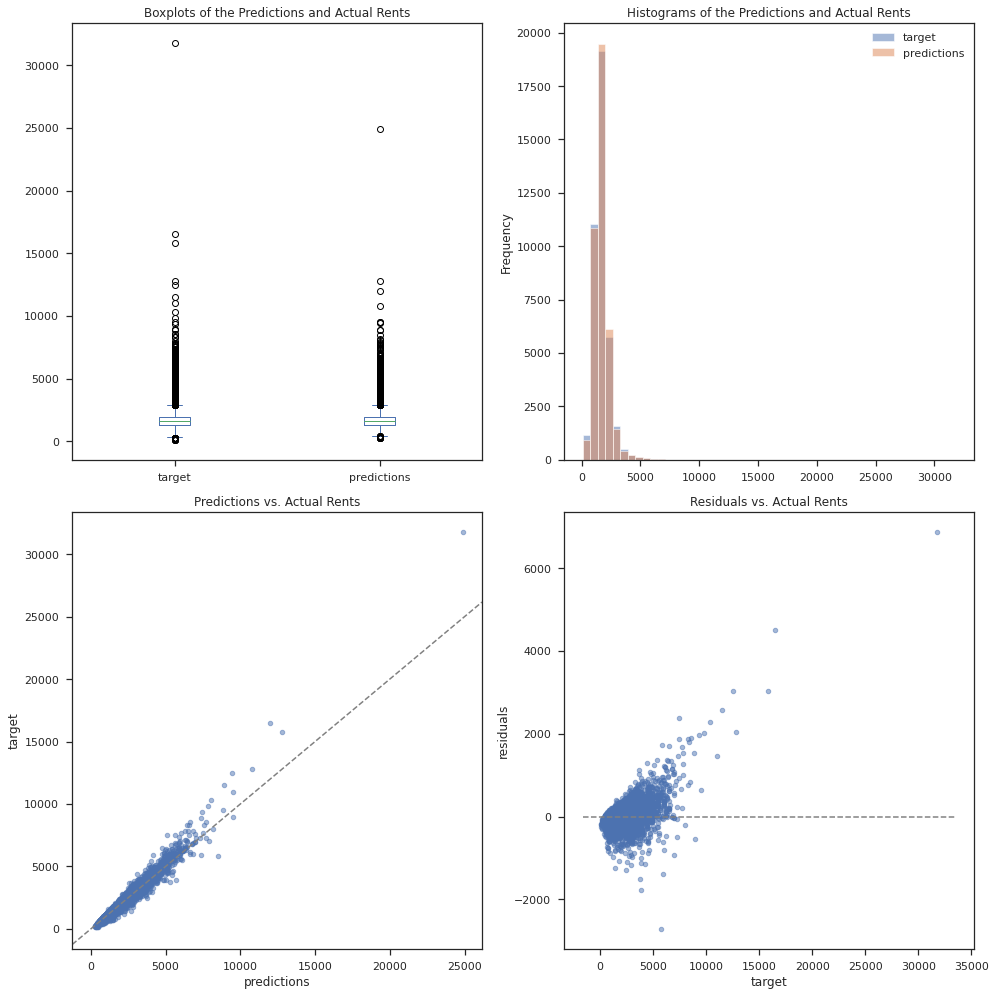

In [344]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger

matplotlib_axes_logger.setLevel("ERROR")

plot_model_predictions(y_train, y_train_pred)

We can see that some of the predictions are below zero. It may be possible to improve this by transforming the original distribution of the rents, since a linear regression model assumes a normal distribution.

The model does fairly well with rents in the normal range, but it is unable to predict outliers accurately. For example, if we say that residuals of +/- CHF 250 are acceptable, we can check what percentage of predictions would fall within this range.

In [311]:
def calc_acceptable_perc(X_train, y_train, y_pred, threshold=100):
    X_train["target"] = y_train
    X_train["predictions"] = y_pred
    X_train["residuals"] = X_train["target"] - X_train["predictions"]

    ok_perc = sum(abs(X_train["residuals"]) <= threshold) / len(X_train)
    
    return ok_perc

In [321]:
print(
    f"{round(100 * calc_acceptable_perc(X_train_feat, y_train, y_train_pred, threshold=250), 2)}% of observations are within the threshold."
)

69.68% of observations are within the threshold.


#### Random Forest Regression

In [322]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model

RandomForestRegressor()

In [323]:
pipeline_rf = Pipeline(steps=[("pre_process", preprocessor), ("model", rf_model)])
pipeline_rf

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='typ-unbekannt',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Wohnungstyp', 'KT', 'Ort']),
                                                 ('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaler',
                                     

In [333]:
pipeline_rf.fit(X_train_feat, y_train)

y_train_pred = pipeline_rf.predict(X_train_feat)

In [334]:
rsq_baseline_rf = r2_score(y_true=y_train, y_pred=y_train_pred)
adj_rsq_baseline_rf = adjusted_r2_score(
    y_true=y_train, y_pred=y_train_pred, X_test=X_train_feat
)
rmse_baseline_rf = mean_squared_error(y_true=y_train, y_pred=y_train_pred) ** 0.5

print("R-sq:", rsq_baseline_rf)
print("Adj. R-sq:", adj_rsq_baseline_rf)
print("RMSE:", rmse_baseline_rf)

R-sq: 0.9657439212968831
Adj. R-sq: 0.9657370242155516
RMSE: 132.26734433081413


In [336]:
print(cross_val_score(pipeline_rf, X_train_feat, y_train, cv=3))

[0.74458587 0.75441878 0.69848688]


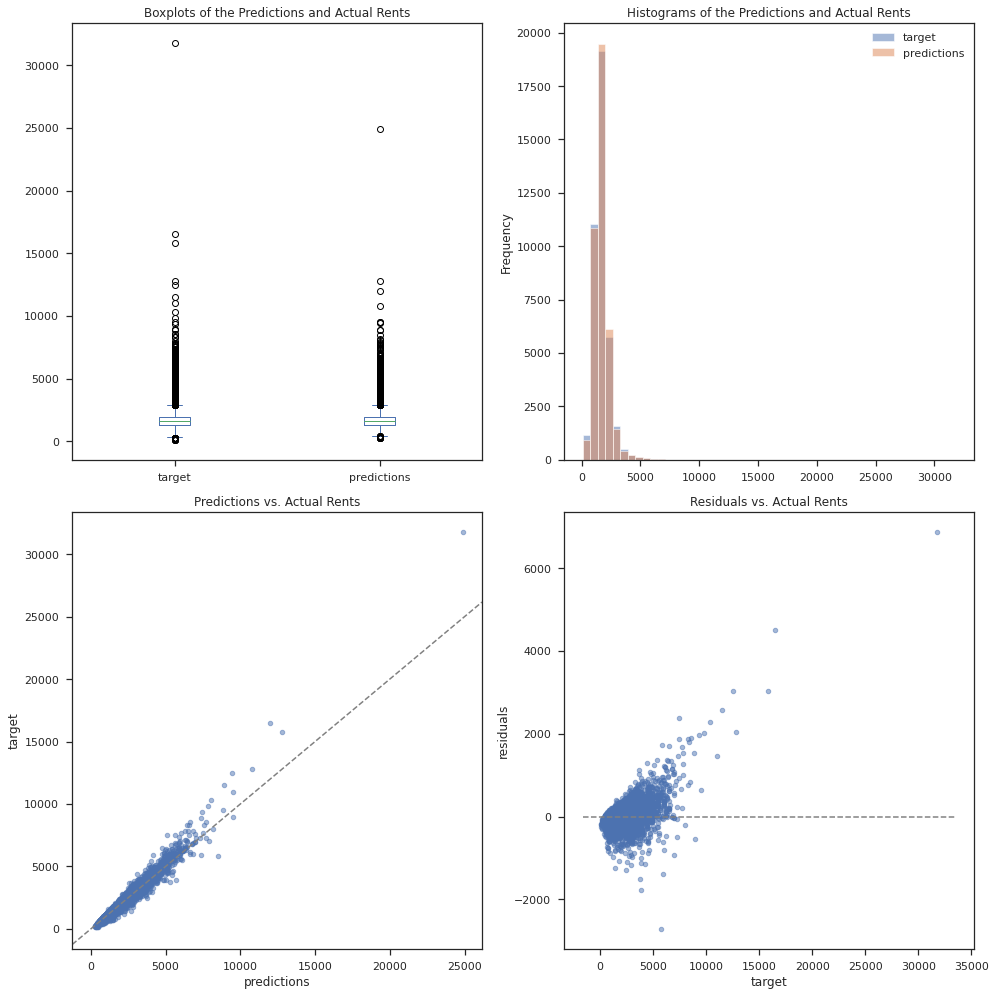

In [345]:
plot_model_predictions(y_train, y_train_pred)

In [338]:
print(
    f"{round(100 * calc_acceptable_perc(X_train_feat, y_train, y_train_pred, threshold=250), 2)}% of observations are within the threshold."
)

96.14% of observations are within the threshold.


### Evaluate the Best Model

In [ ]:
# Clean the test set and select features

X_test_clean = clean_swiss_rents_data(X_test)
X_test_feat = select_swiss_rents_features(X_test_clean, cols_to_select)

In [346]:
# Make predictions and evaluate the performance

y_pred = pipeline_rf.predict(X_test_feat)

rsq_best = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_best = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test_feat)
rmse_best = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5

print("R-sq:", rsq_best)
print("Adj. R-sq:", adj_rsq_best)
print("RMSE:", rmse_best)

R-sq: 0.7595215906868032
Adj. R-sq: 0.7594085905532053
RMSE: 342.89926678438405


<div style="border-top:0.1cm solid #EF475B"></div>
    <strong><a href='#Q0'><div style="text-align: right"> <h3>End of this Notebook.</h3></div></a></strong>